# Sound Classification

The goal of this project is to build a model that accurately classifies various sounds. The classes included are i) Speech ii) Music iii) Animal iv) Vehicle V) Natural Sounds. I went about this in two ways, 1. Using spectrogram images to train a convolutional neural network. 2. extracting numerical features, such as tempo, Mel-frequency cepstral coefficients (MFCCs), chroma features, and spectral features, from the audio files and trained various classification models.

In [210]:
#import relevant packages
import pandas as pd
import numpy as np
from scipy import stats
import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier

import xgboost

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import itertools
from collections import Counter
import re

from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

import librosa
import librosa.display
from librosa import display

from PIL import Image
import os
import pickle
import joblib
from tensorflow.keras.models import load_model

In [43]:
#set a seed to use for random_state inputs for reproducability
SEED = 42

## Data Import / EDA / Initial Preprocessing

Please refer to the 'Audio_Pull' notebook to see how dataset was compiled from the public AudioSet data 
and how audio clips were downloaded
Please refer to the 'Spectrogram_Build' notebook to see how spectrograms were created
Please refer to 'Feature_Extraction' notebook to see how features were extracted from audio files

#### 1. Spectrogram Images

Spectrogram images were created and saved down in the 'Spectrogram_Build' Notebook. Here, I import these images and classification labels.

In [44]:
#In downloading audio and creating spectrograms, some files resulted in an empty audio file and blank, white spetrogram
#This function is designed to filter out any empyty/blank data points
def is_blank_image(image, threshold=0.99):
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Calculate the mean pixel value
    mean_pixel_value = np.mean(image_array)
    # Check if the mean pixel value is below the threshold
    return mean_pixel_value > threshold



In [45]:
#Import images
image_folder_128 = 'specs_sounds_128'
image_files = [file for file in os.listdir(image_folder_128) if file.lower().endswith(('.png'))]


labels = []
images = []

for file in image_files:
    image = Image.open(os.path.join(image_folder_128, file)).convert('RGB').resize((128, 128))
    image = np.array(image) / 255
    
    # Check if the image is mostly blank and skip it if it is not then add to images
    if not is_blank_image(image):
        images.append(image)
        # Extract genre label from the file name and add to labels
        label_label = file.split('_')[0]
        labels.append(label_label)

In [46]:
#check shape of sample image
np.shape(images[52])

(128, 128, 3)

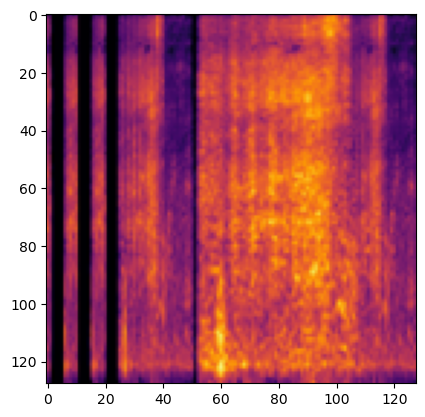

In [47]:
plt.imshow(images[52])

#### 2. Features

In addition to spectrograms, I extracted audio features from the .wav audio files. This code can be found in the 'Feature_Extraction' notebook. These numerical features are used below in various traditional machine learning classification models

In [48]:
#import csv
features1 = pd.read_csv('features/sound_features.csv')

In [49]:
#view subset
features1.head()

,file_name,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,...,mfcc_8,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
0,Speech_FT9BbKuz-vU.wav,0.301010,0.259437,0.293284,0.362778,0.340532,0.335875,0.346284,0.372173,0.331058,...,-7.710987,-3.804535,-1.328928,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135
1,Music_DHKXX1PUjdI.wav,0.325412,0.349722,0.245324,0.375099,0.303990,0.497178,0.448995,0.296847,0.416099,...,4.713310,-15.556738,2.608249,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832
2,Animal_5R5te67I7Xg.wav,0.582531,0.527832,0.530989,0.536541,0.560560,0.594938,0.614481,0.596575,0.616836,...,9.674698,-8.673678,12.313059,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886
3,Music_JrUv5Y3WfZE.wav,0.503122,0.541557,0.505742,0.556515,0.458776,0.511832,0.452019,0.336280,0.382063,...,11.218300,1.920732,5.678011,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886
4,Vehicle_m27VWjIQ8xE.wav,0.468376,0.395917,0.363609,0.446638,0.776172,0.717686,0.624416,0.524692,0.368461,...,11.268492,-1.872054,1.946786,123.046875,117.453835,0.033297,0.026709,0.034495,1.133868,0.400705


In [50]:
#view stats
features1.describe()

,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,...,mfcc_8,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
count,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,...,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000,11506.000000,11506.000000
mean,0.445124,0.448235,0.437311,0.444498,0.435872,0.441689,0.436877,0.436321,0.450010,0.449452,...,1.797081,-4.775362,1.777955,124.017034,124.568667,0.113921,0.091688,0.126788,2.693016,19.774286
std,0.116088,0.153318,0.151336,0.152694,0.152231,0.150300,0.152902,0.150045,0.152877,0.154191,...,10.781307,10.529575,8.542043,30.717060,16.368973,0.106495,0.090216,0.109321,3.268648,148.253480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-40.640644,-55.929787,-42.198180,0.000000,37.999770,0.000100,0.000000,0.000000,-2.846342,-1.920252
25%,0.361761,0.343473,0.333127,0.341153,0.328726,0.338765,0.331516,0.331408,0.342973,0.342525,...,-4.629341,-11.144189,-3.203602,103.359375,117.453835,0.033662,0.025756,0.045110,1.220457,0.528835
50%,0.441745,0.445749,0.432571,0.440359,0.430245,0.436414,0.430907,0.432888,0.446723,0.446865,...,2.340380,-4.923871,2.066053,123.046875,123.046875,0.085724,0.066757,0.101219,1.847078,2.529473
75%,0.535804,0.556582,0.543423,0.549679,0.543422,0.546677,0.540700,0.540381,0.555775,0.554773,...,8.755608,1.207179,7.094517,143.554688,129.199219,0.164766,0.131842,0.178797,3.019915,8.982500
max,0.795711,0.999620,0.997939,1.000000,0.986985,0.999965,1.000000,0.985916,0.980005,1.000000,...,54.896946,42.751540,40.905052,287.109375,287.109375,0.914878,0.899041,0.916322,84.544132,9215.784088


In [51]:
#Extract class labels from the audio file names and create label column
def extract_label(filename):
    return filename.split('_')[0]

features1['label'] = features1['file_name'].apply(extract_label)

In [52]:
features1.head()

,file_name,global_mean_chroma_stft,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,...,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Speech_FT9BbKuz-vU.wav,0.301010,0.259437,0.293284,0.362778,0.340532,0.335875,0.346284,0.372173,0.331058,...,-3.804535,-1.328928,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135,Speech
1,Music_DHKXX1PUjdI.wav,0.325412,0.349722,0.245324,0.375099,0.303990,0.497178,0.448995,0.296847,0.416099,...,-15.556738,2.608249,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832,Music
2,Animal_5R5te67I7Xg.wav,0.582531,0.527832,0.530989,0.536541,0.560560,0.594938,0.614481,0.596575,0.616836,...,-8.673678,12.313059,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886,Animal
3,Music_JrUv5Y3WfZE.wav,0.503122,0.541557,0.505742,0.556515,0.458776,0.511832,0.452019,0.336280,0.382063,...,1.920732,5.678011,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886,Music
4,Vehicle_m27VWjIQ8xE.wav,0.468376,0.395917,0.363609,0.446638,0.776172,0.717686,0.624416,0.524692,0.368461,...,-1.872054,1.946786,123.046875,117.453835,0.033297,0.026709,0.034495,1.133868,0.400705,Vehicle


In [53]:
#View label split. Dataset is fairly balanced.
features1['label'].value_counts()

label
Speech     0.267958
Vehicle    0.258577
Music      0.249978
Animal     0.223486
Name: proportion, dtype: float64

In [54]:
#View class split %
features1['label'].value_counts(normalize=True)

label
Speech     0.267958
Vehicle    0.258577
Music      0.249978
Animal     0.223486
Name: proportion, dtype: float64

In compiling the features dataset, I included both the global average and averages for each pitch class for features where this is relevant, such as chroma_stft which computes a chromagram from a given audio file or spectrogram. Below I split the dataset into two datagframes. One with 64 features that excludes the global averages and one with 16 features that includes only the global averages for features that have both. 

In [55]:
to_drop = features1.filter(like='global')
featuresdf = features1.drop(columns=to_drop)
featuresdf.head()

,file_name,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,...,mfcc_9,mfcc_10,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Speech_FT9BbKuz-vU.wav,0.259437,0.293284,0.362778,0.340532,0.335875,0.346284,0.372173,0.331058,0.200515,...,-3.804535,-1.328928,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135,Speech
1,Music_DHKXX1PUjdI.wav,0.349722,0.245324,0.375099,0.303990,0.497178,0.448995,0.296847,0.416099,0.225963,...,-15.556738,2.608249,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832,Music
2,Animal_5R5te67I7Xg.wav,0.527832,0.530989,0.536541,0.560560,0.594938,0.614481,0.596575,0.616836,0.650267,...,-8.673678,12.313059,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886,Animal
3,Music_JrUv5Y3WfZE.wav,0.541557,0.505742,0.556515,0.458776,0.511832,0.452019,0.336280,0.382063,0.542141,...,1.920732,5.678011,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886,Music
4,Vehicle_m27VWjIQ8xE.wav,0.395917,0.363609,0.446638,0.776172,0.717686,0.624416,0.524692,0.368461,0.382808,...,-1.872054,1.946786,123.046875,117.453835,0.033297,0.026709,0.034495,1.133868,0.400705,Vehicle


In [56]:
featuresdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11513 entries, 0 to 11512
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            11513 non-null  object 
 1   chroma_stft_1        11513 non-null  float64
 2   chroma_stft_2        11513 non-null  float64
 3   chroma_stft_3        11513 non-null  float64
 4   chroma_stft_4        11513 non-null  float64
 5   chroma_stft_5        11513 non-null  float64
 6   chroma_stft_6        11513 non-null  float64
 7   chroma_stft_7        11513 non-null  float64
 8   chroma_stft_8        11513 non-null  float64
 9   chroma_stft_9        11513 non-null  float64
 10  chroma_stft_10       11513 non-null  float64
 11  chroma_stft_11       11513 non-null  float64
 12  chroma_stft_12       11513 non-null  float64
 13  chroma_cens_1        11513 non-null  float64
 14  chroma_cens_2        11513 non-null  float64
 15  chroma_cens_3        11513 non-null 

In [57]:
to_drop = features1.filter(regex=r'\d', axis=1)
features_global = features1.drop(columns=to_drop)

In [58]:
features_global.head()

,file_name,global_mean_chroma_stft,global_mean_cens,global_mean_cqt,spectral_centroid,spectral_bandwidth,global_mean_spectral_contrast,spectral_rolloff,zero_crossing_rate,global_mean_mfcc,beat_track_tempo,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis,label
0,Speech_FT9BbKuz-vU.wav,0.301010,0.254810,0.433946,2210.245625,2270.885708,23.212639,4676.876824,0.155660,-14.389880,95.703125,129.199219,0.060157,0.047779,0.076274,2.264745,4.708135,Speech
1,Music_DHKXX1PUjdI.wav,0.325412,0.229826,0.417721,1456.064226,1695.457465,22.854893,2888.496841,0.069649,3.407117,129.199219,129.199219,0.252015,0.204956,0.253555,0.822353,-0.287832,Music
2,Animal_5R5te67I7Xg.wav,0.582531,0.282630,0.716117,2089.011469,2489.015507,20.177914,5017.511114,0.055304,-14.381475,135.999178,123.046875,0.012570,0.010128,0.013004,1.849239,1.694886,Animal
3,Music_JrUv5Y3WfZE.wav,0.503122,0.265133,0.577625,1663.411735,2153.812351,20.802665,3688.747610,0.045547,12.832295,143.554688,143.554688,0.345786,0.290247,0.353646,0.604745,-0.581886,Music
4,Vehicle_m27VWjIQ8xE.wav,0.468376,0.273554,0.474365,880.953548,1014.702691,22.184765,1691.854890,0.046465,-9.100744,123.046875,117.453835,0.033297,0.026709,0.034495,1.133868,0.400705,Vehicle


In [59]:
features_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11513 entries, 0 to 11512
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   file_name                      11513 non-null  object 
 1   global_mean_chroma_stft        11513 non-null  float64
 2   global_mean_cens               11513 non-null  float64
 3   global_mean_cqt                11513 non-null  float64
 4   spectral_centroid              11513 non-null  float64
 5   spectral_bandwidth             11513 non-null  float64
 6   global_mean_spectral_contrast  11513 non-null  float64
 7   spectral_rolloff               11513 non-null  float64
 8   zero_crossing_rate             11513 non-null  float64
 9   global_mean_mfcc               11513 non-null  float64
 10  beat_track_tempo               11513 non-null  float64
 11  feature_tempo                  11513 non-null  float64
 12  mean_rms                       11513 non-null 

In [60]:
#dropping na's
features_global.dropna(inplace=True)
featuresdf.dropna(inplace=True)

In [61]:
#there are two librosa functions to extract tempo from audio. Here we drop one of them to avoid multicollinearity
featuresdf.drop(columns='beat_track_tempo', inplace=True)
features_global.drop(columns='beat_track_tempo', inplace=True)

Now we'll take a look at features by class.

In [62]:
class_df = featuresdf.groupby('label').mean(numeric_only=True)

In [63]:
class_df

,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,feature_tempo,mean_rms,signal mean,signal stdev,signal skewness,signal kurtosis
label,,,,,,,,,,,,,,,,,,,,,
Animal,0.487373,0.479273,0.483309,0.476230,0.472599,0.473608,0.471860,0.479870,0.484322,0.490340,...,-2.991067,1.873721,-3.449763,1.180168,124.196899,0.045434,0.035660,0.060444,5.035831,63.104886
Music,0.396570,0.371880,0.392415,0.376425,0.398299,0.381346,0.379748,0.407257,0.402404,0.419865,...,-1.902637,4.016468,-3.854998,3.389843,125.018740,0.185717,0.151295,0.197405,1.369882,1.424434
Speech,0.414761,0.403357,0.405017,0.396041,0.399388,0.398809,0.402561,0.415306,0.414248,0.422402,...,-7.171560,-2.077441,-7.465874,0.232158,124.737103,0.080212,0.062766,0.095839,2.832240,14.091902
Vehicle,0.500087,0.500498,0.503258,0.500755,0.501798,0.499284,0.496298,0.502553,0.502330,0.502330,...,-2.199013,3.607326,-4.033165,2.344065,124.297299,0.138992,0.112748,0.148310,1.800809,5.917750


In [64]:
#Here I create function that checks for highly correlated features. 
#We also determine how to handle multicollinearity below.
def check_correlation(df, threshold=0.7):
    df = df.select_dtypes(include='number')
    
    correlation_matrix = df.corr()

    correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                correlation_percentage = abs(correlation_matrix.iloc[i, j]) * 100
                correlated_pairs.append((feature1, feature2, correlation_percentage))

    # Print the correlated feature pairs
    if correlated_pairs:
        print("Correlated Feature Pairs:")
        for pair in correlated_pairs:
            print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}% correlation")
    else:
        print("No features are correlated above the specified threshold.")

In [65]:
#check correlation of features in full feature df
check_correlation(featuresdf, threshold=0.70)

Correlated Feature Pairs:
chroma_stft_1 and chroma_stft_2: 79.35% correlation
chroma_stft_1 and chroma_stft_12: 79.61% correlation
chroma_stft_2 and chroma_stft_3: 79.01% correlation
chroma_stft_3 and chroma_stft_4: 79.79% correlation
chroma_stft_4 and chroma_stft_5: 78.50% correlation
chroma_stft_5 and chroma_stft_6: 77.87% correlation
chroma_stft_6 and chroma_stft_7: 79.42% correlation
chroma_stft_7 and chroma_stft_8: 77.83% correlation
chroma_stft_8 and chroma_stft_9: 77.93% correlation
chroma_stft_9 and chroma_stft_10: 79.13% correlation
chroma_stft_10 and chroma_stft_11: 78.22% correlation
chroma_stft_11 and chroma_stft_12: 81.61% correlation
chroma_cens_1 and chroma_cqt_1: 78.48% correlation
chroma_cens_2 and chroma_cqt_2: 81.87% correlation
chroma_cens_3 and chroma_cqt_3: 78.20% correlation
chroma_cens_4 and chroma_cqt_4: 82.10% correlation
chroma_cens_5 and chroma_cqt_5: 78.10% correlation
chroma_cens_6 and chroma_cqt_6: 79.40% correlation
chroma_cens_7 and chroma_cqt_7: 79.56%

In [66]:
#check correlation of features in consolidated global feature df
check_correlation(features_global, threshold=0.70)

Correlated Feature Pairs:
global_mean_cens and global_mean_cqt: 87.34% correlation
spectral_centroid and spectral_bandwidth: 80.76% correlation
spectral_centroid and spectral_rolloff: 95.40% correlation
spectral_centroid and zero_crossing_rate: 87.77% correlation
spectral_bandwidth and spectral_rolloff: 90.56% correlation
spectral_rolloff and zero_crossing_rate: 72.92% correlation
global_mean_mfcc and mean_rms: 72.36% correlation
global_mean_mfcc and signal mean: 70.76% correlation
mean_rms and signal mean: 99.77% correlation
mean_rms and signal stdev: 99.05% correlation
signal mean and signal stdev: 98.70% correlation
signal skewness and signal kurtosis: 79.45% correlation


As you can see above, there many features are siginificantly correlated. This is addressed with Principal Component Analysis (PCA) in our models below. PCA is dimensionality reduction technique that aims to transform high-dimensional data into a new cooridinate system, reducing dimensionality while perserving variance as much as possible. 

## Additional Preprocessing

#### 1. Spectrogram Images

Here, I split the image dataset into a train and test set, and one hot encode the class labels using TensorFlow's to_categorical. Although a validation set is not defined here, we do define a validation split in our CNN model below.

In [79]:
#train_test split image dataset
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=SEED)

In [80]:
#one hot encode labels for train set
labels_unique = list(set(labels))
label_to_index = {label: index for index, label in enumerate(labels_unique)}
y_train_num_labels = [label_to_index[label] for label in y_train_img]
y_train_img_onehot = to_categorical(y_train_num_labels)

In [81]:
#one hot encode labels for test set
y_test_num_labels = [label_to_index[label] for label in y_test_img]
y_test_img_onehot = to_categorical(y_test_num_labels)

In [176]:
#display label mapping for reference
index_to_label = {index: label for label, index in label_to_index.items()}
for index, label in index_to_label.items():
    print(f"Number: {index}, Label: {label}")

#define class_labels for future use
class_labels = [index_to_label[index] for index in range(len(labels_unique))]
class_labels

Number: 0, Label: Speech
Number: 1, Label: Animal
Number: 2, Label: Vehicle
Number: 3, Label: Music


['Speech', 'Animal', 'Vehicle', 'Music']

In [82]:
#set as arrays
X_train_img = np.array(X_train_img)
X_test_img = np.array(X_test_img)

In [83]:
#check shape of X
np.shape(X_train_img)

(9234, 128, 128, 3)

In [84]:
#check shape y
np.shape(y_train_img_onehot)

(9234, 4)

#### 3. Features

Here, I split the feature dataset into a train and test set. Additionally preprocessing such as scaling the data and performing PCA on the data is conducted in the model pipelines below.

In [85]:
#train_test split feature data
X_feat = featuresdf.drop(columns=['file_name', 'label'])
y_feat = featuresdf['label']
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(X_feat, y_feat, random_state=SEED)

In [86]:
X_featglobal = features_global.drop(columns=['file_name', 'label'])
y_featglobal = features_global['label']
X_train_featglobal, X_test_featglobal, y_train_featglobal, y_test_featglobal = train_test_split(X_featglobal, y_featglobal, random_state=SEED)

## Modeling with Spectrograms

#### CNN - Image Classification

In [148]:
#define early stopping based on validation accuracy scores
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,         
                               restore_best_weights=True) 

In [154]:
#define CNN with 3 layers
model01 = Sequential()

#layer one
model01.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        input_shape=(128, 128, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))

#layer two
model01.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))

#layer three
model01.add(Conv2D(filters=64,
                        kernel_size=(3, 3)))
model01.add(BatchNormalization())
model01.add(ReLU())
model01.add(MaxPooling2D(pool_size=(2, 2)))


#conduct final pooling using GlobalAveragePooling2D
model01.add(GlobalAveragePooling2D())


#output layer
#transition to fully connected dense layer
model01.add(Dense(4, activation='softmax'))

In [155]:
#compile model
model01.compile(optimizer=Adam(), loss='categorical_crossentropy',  metrics=['accuracy'])

In [156]:
#fit on train set
history01 = model01.fit(X_train_img, y_train_img_onehot, epochs=20, batch_size=32, verbose = 2, 
                        validation_split=.2, callbacks=early_stopping)

Epoch 1/20
231/231 - 45s - loss: 0.8609 - accuracy: 0.6694 - val_loss: 2.9604 - val_accuracy: 0.2637 - 45s/epoch - 196ms/step
Epoch 2/20
231/231 - 45s - loss: 0.7384 - accuracy: 0.7274 - val_loss: 2.2797 - val_accuracy: 0.3173 - 45s/epoch - 197ms/step
Epoch 3/20
231/231 - 62s - loss: 0.6938 - accuracy: 0.7497 - val_loss: 1.1097 - val_accuracy: 0.5647 - 62s/epoch - 270ms/step
Epoch 4/20
231/231 - 83s - loss: 0.6659 - accuracy: 0.7605 - val_loss: 0.6744 - val_accuracy: 0.7666 - 83s/epoch - 358ms/step
Epoch 5/20
231/231 - 77s - loss: 0.6402 - accuracy: 0.7705 - val_loss: 0.9133 - val_accuracy: 0.6502 - 77s/epoch - 335ms/step
Epoch 6/20
231/231 - 68s - loss: 0.6284 - accuracy: 0.7754 - val_loss: 0.7960 - val_accuracy: 0.6909 - 68s/epoch - 293ms/step
Epoch 7/20
231/231 - 72s - loss: 0.6142 - accuracy: 0.7770 - val_loss: 0.9228 - val_accuracy: 0.6757 - 72s/epoch - 313ms/step
Epoch 8/20
231/231 - 80s - loss: 0.6067 - accuracy: 0.7815 - val_loss: 0.7319 - val_accuracy: 0.7168 - 80s/epoch - 348

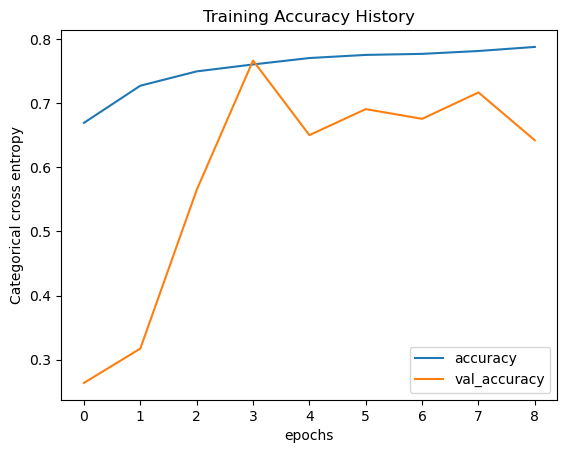

In [157]:
#visualize train and validation accuracy
train_history = pd.DataFrame(history01.history)
train_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training Accuracy History')
plt.show()

In [158]:
#save scores for future use
#cnn_img_train_acc = history01.history['accuracy'][-1]
#cnn_img_val_acc = history01.history['val_accuracy'][-1]

cnn_img_val_acc = max(history01.history['val_accuracy'])
best_val_epoch = np.argmax(history01.history['val_accuracy'])
cnn_img_train_acc = history01.history['accuracy'][best_val_epoch]

In [159]:
cnn_img_train_acc, cnn_img_val_acc

(0.7605252265930176, 0.7666485905647278)

## Modeling with Extracted Features Dataset

1. Random Forest
2. Logistic Regression
3. AdaBoost Classifier
4. XGBoost Classifier

#### 1. Random Forest

In [97]:
rfc = RandomForestClassifier(random_state=SEED)
rfc_model_pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components = 7)), ('rfc', rfc)])

In [98]:
rfc_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [99]:
rfc_model_pipe.score(X_train_feat, y_train_feat)

0.9998841117163055

In [100]:
params_rfc = {
    'rfc__n_estimators': [100, 200],
    'rfc__min_samples_split': [2, 3, 4],
    'rfc__min_samples_leaf': [3, 4],
    'rfc__max_depth': [3, 7, 10],
    'rfc__criterion': ['gini'],
    'pca__n_components': [10, 25, 50]}

rfc_gs_cv = GridSearchCV(estimator=rfc_model_pipe, param_grid=params_rfc,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
rfc_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(rfc_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'pca__n_components': 50, 'rfc__criterion': 'gini', 'rfc__max_depth': 10, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 200}
Time taken: 542.5335297584534 seconds


In [101]:
rfc_best_model = rfc_gs_cv.best_estimator_
rfc_best_train_score = rfc_gs_cv.cv_results_['mean_train_score'][rfc_gs_cv.best_index_]
rfc_best_test_score = rfc_gs_cv.best_score_

print('RFC Best Model:', rfc_best_model)
print("RFC Best Model Train Accuracy Score:", rfc_best_train_score)
print("RFC Best Model Test Accuracy Score:", rfc_best_test_score)

RFC Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=4, n_estimators=200,
                                        random_state=42))])
RFC Best Model Train Accuracy Score: 0.8830686773166502
RFC Best Model Test Accuracy Score: 0.7095836175483496


In [102]:
#Let's try fitting rfc on dataset with fewer features 
#(relevant features are reduced to global average as opposed to per pitch class average)
rfc_model_pipe.fit(X_train_featglobal, y_train_featglobal)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=7)),
                ('rfc', RandomForestClassifier(random_state=42))])

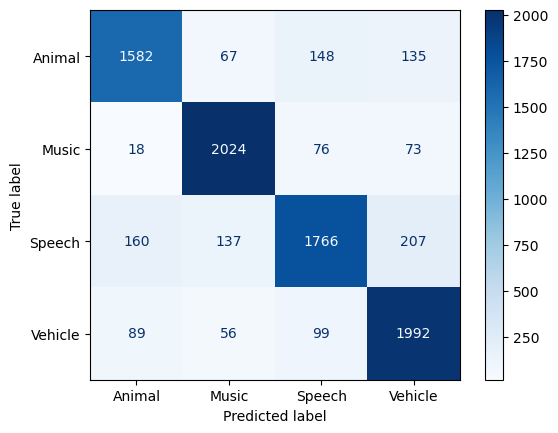

In [103]:
#display confusion matrix
ConfusionMatrixDisplay.from_estimator(rfc_best_model, X_train_feat, y_train_feat, cmap='Blues')

#### 2. Logistic Regression

In [104]:
lgr_model_pipe = Pipeline([('scaler', StandardScaler()),('pca', PCA(n_components = 10)), ('model', LogisticRegression(solver='newton-cg', random_state=SEED))])
lgr_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model',
                 LogisticRegression(random_state=42, solver='newton-cg'))])

In [105]:
lgr_model_pipe.score(X_train_feat, y_train_feat)

0.617105110673311

In [106]:
params_lgr = {
    'model__penalty': ['l2', 'l1', None],
    'model__tol': [0.0001, .001],
    'model__C': [.05, .1, 1],
    'model__max_iter': [100, 200],
    'model__solver': ['newton-cg', 'sag', 'saga'],
    'pca__n_components': [25, 50, 60]}

lgr_gs_cv = GridSearchCV(estimator=lgr_model_pipe, param_grid=params_lgr,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
lgr_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(lgr_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

{'model__C': 0.1, 'model__max_iter': 200, 'model__penalty': 'l2', 'model__solver': 'sag', 'model__tol': 0.0001, 'pca__n_components': 60}
Time taken: 401.9635579586029 seconds


/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [107]:
lgr_best_model = lgr_gs_cv.best_estimator_
lgr_best_train_score = lgr_gs_cv.cv_results_['mean_train_score'][lgr_gs_cv.best_index_]
lgr_best_test_score = lgr_gs_cv.best_score_

print('Log Regression Best Model:', lgr_best_model)
print("Log Regression Best Model Train Accuracy Score:", lgr_best_train_score)
print("Log Regression Best Model Test Accuracy Score:", lgr_best_test_score)

Log Regression Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=60)),
                ('model',
                 LogisticRegression(C=0.1, max_iter=200, random_state=42,
                                    solver='sag'))])
Log Regression Best Model Train Accuracy Score: 0.7252869156734335
Log Regression Best Model Test Accuracy Score: 0.7180439190555634


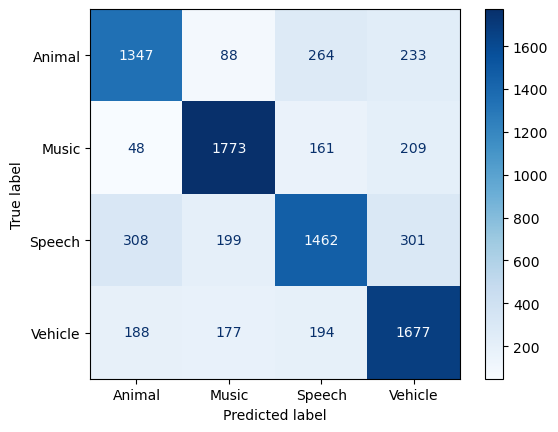

In [108]:
#display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgr_best_model, X_train_feat, y_train_feat, cmap='Blues')

#### 3. AdaBoost Classifier

Per the documentation, An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [109]:
ada_boost_model = AdaBoostClassifier(n_estimators=25, estimator=DecisionTreeClassifier(),
                                     learning_rate=0.5, random_state=SEED)

In [110]:
ada_model_pipe = Pipeline([('scaler', StandardScaler()),
                           ('pca', PCA(n_components=40)),
                           ('model', ada_boost_model)])
ada_model_pipe.fit(X_train_feat, y_train_feat)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=40)),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                    learning_rate=0.5, n_estimators=25,
                                    random_state=42))])

In [111]:
ada_model_pipe.score(X_train_feat, y_train_feat)

0.999768223432611

In [112]:
params_ada = {
    'pca__n_components': [40, 50],
    'model__learning_rate': [0.5, 1],
    'model__estimator': [RandomForestClassifier()],
    'model__estimator__max_depth': [5, 7, 10]
}

ada_gs_cv = GridSearchCV(estimator=ada_model_pipe, param_grid=params_ada,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
ada_gs_cv.fit(X_train_feat, y_train_feat)
end_time = time.time()

print(ada_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'model__estimator': RandomForestClassifier(), 'model__estimator__max_depth': 10, 'model__learning_rate': 1, 'pca__n_components': 40}
Time taken: 1175.581859111786 seconds


In [113]:
ada_best_model = ada_gs_cv.best_estimator_
ada_best_train_score = ada_gs_cv.cv_results_['mean_train_score'][ada_gs_cv.best_index_]
ada_best_test_score = ada_gs_cv.best_score_

print('AdaBoost Best Model:', ada_best_model)
print("AdaBoost Best Model Train Accuracy Score:", ada_best_train_score)
print("AdaBoost Best Model Test Accuracy Score:", ada_best_test_score)

AdaBoost Best Model: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=40)),
                ('model',
                 AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=10),
                                    learning_rate=1, n_estimators=25,
                                    random_state=42))])
AdaBoost Best Model Train Accuracy Score: 0.9994784926467181
AdaBoost Best Model Test Accuracy Score: 0.737860936956396


#### 4. XG Boost Classifier

XGBoost is a gradient boosting library. It provides a parallel tree boosting (also known as GBDT, GBM) that can solve various DS problems.

In [114]:
#Need to convert categorical labels to numbers for use in XG Boost
#instantiate label encoder
label_encoder = LabelEncoder()

#fit transform train
y_train_feat_encoded = label_encoder.fit_transform(y_train_feat)

#transform test
y_test_feat_encoded = label_encoder.transform(y_test_feat)

In [121]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'Animal': 0, 'Music': 1, 'Speech': 2, 'Vehicle': 3}

In [115]:
xg_boost_model = xgboost.XGBClassifier(random_state=SEED, booster='gbtree', objective='multi:softmax', num_class=len(label_encoder.classes_))

In [116]:
xg_model_pipe = Pipeline([('scaler', StandardScaler()), 
                           ('model', xg_boost_model)])
xg_model_pipe.fit(X_train_feat, y_train_feat_encoded)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_class=4, num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [117]:
xg_model_pipe.score(X_train_feat, y_train_feat_encoded)

1.0

In [118]:
params_xg = {
    'model__learning_rate': [0.1, 0.3],
    'model__n_estimators': [50, 100],
    'model__max_depth': [7, 10],
    'model__colsample_bytree': [0.8, 1.0]
}

xg_gs_cv = GridSearchCV(estimator=xg_model_pipe, param_grid=params_xg,
                        cv=3, scoring='accuracy', return_train_score=True, 
                         verbose=1)

start_time = time.time()
xg_gs_cv.fit(X_train_feat, y_train_feat_encoded)
end_time = time.time()

print(xg_gs_cv.best_params_)
print("Time taken:", end_time - start_time, "seconds")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.3, 'model__max_depth': 7, 'model__n_estimators': 100}
Time taken: 272.81808733940125 seconds


In [119]:
xg_best_model = xg_gs_cv.best_estimator_
xg_best_train_score = xg_gs_cv.cv_results_['mean_train_score'][xg_gs_cv.best_index_]
xg_best_test_score = xg_gs_cv.best_score_

print('Log Regression Best Model:', xg_best_model)
print("Log Regression Best Model Train Accuracy Score:", xg_best_train_score)
print("Log Regression Best Model Test Accuracy Score:", xg_best_test_score)

Log Regression Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.8,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=No

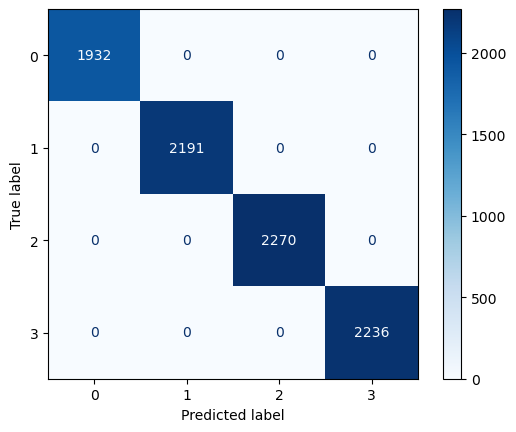

In [120]:
#display confusion matrix
ConfusionMatrixDisplay.from_estimator(xg_best_model, X_train_feat, y_train_feat_encoded, cmap='Blues')

### Model Comparison

In [160]:
#Creat bar chart to compare train test scores
model_names = ['Random Forest', 'Logistic Regression', 'AdaBoost Classifier', 
               'XGBoost Classifier', 'CNN Image Classification Model']

train_scores = [rfc_best_train_score, lgr_best_train_score, ada_best_train_score, xg_best_train_score,cnn_img_train_acc]

test_scores = [rfc_best_test_score, lgr_best_test_score, ada_best_test_score, xg_best_test_score, cnn_img_val_acc]

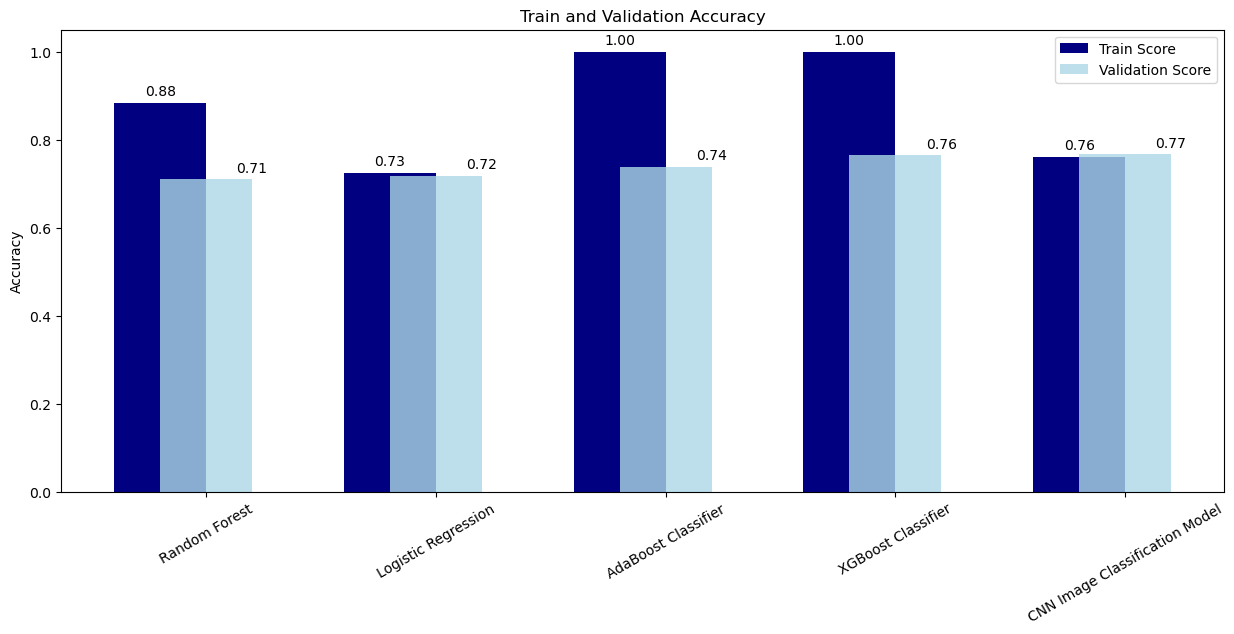

In [161]:
# Create bar chart comparing test and val scores for each model
bar_width = 0.4
fig, ax = plt.subplots(figsize=(15, 6))

# Create x labels
x = range(len(model_names))

# Plot scores
train_bars = ax.bar(x, train_scores, bar_width, label='Train Score', color='navy')
test_bars = ax.bar(x, test_scores, bar_width, label='Validation Score', color='lightblue', alpha=0.8, align='edge')

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(model_names, rotation=30)

#Label bars
for i, (train_bar, test_bar) in enumerate(zip(train_bars, test_bars)):
    ax.text(i, train_bar.get_height() + 0.01, f'{train_scores[i]:.2f}', ha='center', va='bottom')
    ax.text(i + bar_width, test_bar.get_height() + 0.01, f'{test_scores[i]:.2f}', ha='center', va='bottom')

ax.legend()
ax.set_ylabel('Accuracy')
ax.set_title('Train and Validation Accuracy')

plt.show()

### Best Traditional ML Model - Feature Importance

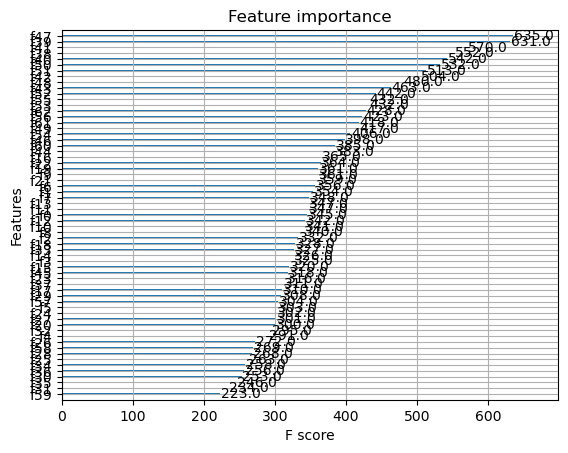

In [188]:
#Plot feature importances for xgboost model, as this was our best performing traditional ML model and we are
#interested in exploring which numerical features are most impactful
xgboost.plot_importance(xg_best_model.named_steps['model'], importance_type='weight')
plt.show()

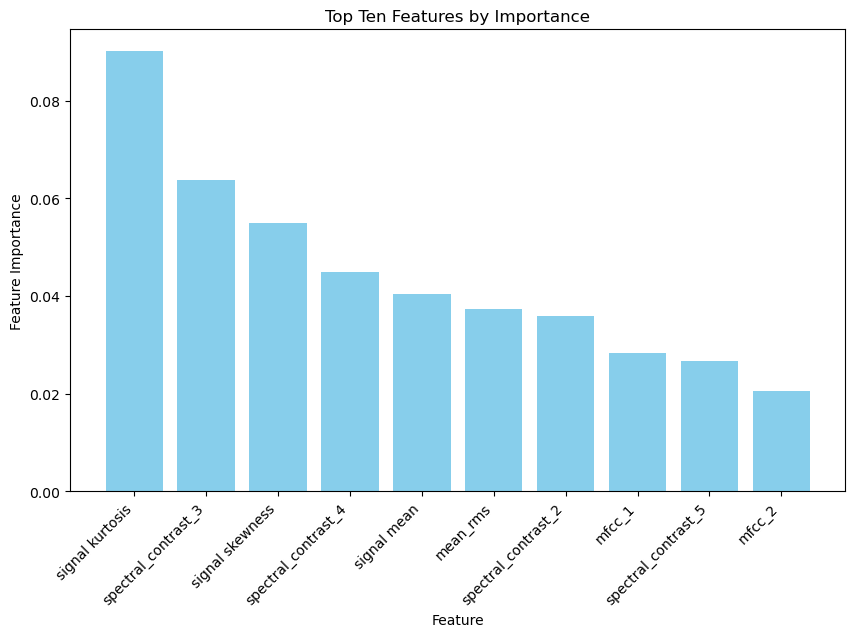

In [206]:
#Above is difficult to read, let's plot the top ten most impactful features
importances = xg_best_model.named_steps['model'].feature_importances_
feature_names = X_train_feat.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_ten_importance = importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_ten_importance['Feature'], top_ten_importance['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Top Ten Features by Importance')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

### Evaluate Model on Unseen Test Data

The best performing model is the CNN image classification model. Not only is this model not overfitting like many of the other models, it also produces the highest accuracy score on validation data. We'll now test our final model on unseen data.

In [213]:
#set best_model based on best performing model shown above
best_model = model01

In [214]:
y_true = np.argmax(y_test_img_onehot, axis=1)
y_pred = np.argmax(best_model.predict(X_test_img), axis=1)

73/73 [==============================] - 3s 43ms/step


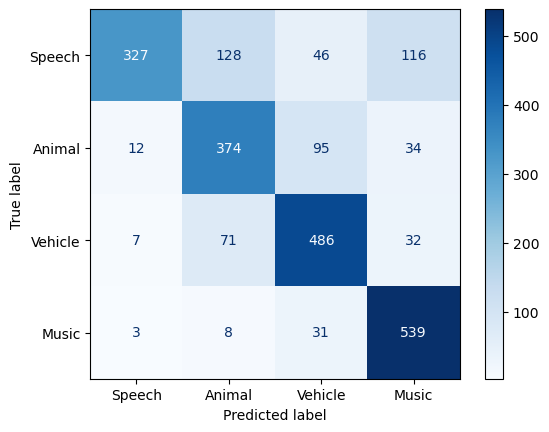

In [216]:
#display confusion matrix
display = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_labels, cmap='Blues')

In [215]:
accuracy_score(y_true, y_pred)

0.747509744478129

In [217]:
precision_score(y_true, y_pred, average='weighted')

0.7727012299245024

In [218]:
recall_score(y_true, y_pred, average='weighted')

0.747509744478129

In [219]:
f1_score(y_true, y_pred, average='weighted')

0.741538718797275

### Save Final Model

In [220]:
#save model using pickle
model01.save('sound_classifier.h5')

/Users/emilykrueger/anaconda3/envs/learn2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
